# Exploring Unfairness in Data

## Learning Objectives
* Understanding and Applying Linear Regression 
* Data Exploration
* Practice ML Workflow: Training, Testing, and Evaluation

## Credits
This assignment was published at the Symposium on Educational Advances in Artificial Intelligence, 2020, and slightly modified to suit this course.

[Chen, Larsen and Neumann, Exploring Unfairness and Bias in Data, EAAI 2020](http://modelai.gettysburg.edu/2020/bias/)

## Outline

1. [Unfairness](#1.-Unfairness)
2. [Exploring Loan Approval Data](#2.-Exploring-Loan-Approval-Data)
3. [Building a Model](#3.-Building-a-Model)
4. [Becoming Data and Fairness Aware](#4.-Becoming-Data-and-Fairness-Aware)

## 1. Unfairness

It is natural to assume that a model built from "real-world" data will inherently represent the world at large. We often take the data that we have for granted, especially when we are first getting started with building AI systems. However, if we do not pay attention to what our data look like, how they were collected, and what features they contain, we may unknowingly create models that propagate cultural biases and unfairness.

![hire](utility/images/undraw_hire_te5y.png)

In 2014, Amazon began building programs that could automate the hiring process for engineers. They wanted a machine to be able to pick out the top resumes from the thousands they receive every year. They trained their model on all of the resumes that they had, hoping that the model would be able to identify trends in keyword frequency within those applications. If most applications contained the word "intern," then one might reasonably expect that a resume containing it would be ranked higher than one that doesn't. However, as they began to deploy their model, it became increasingly apparent that the model was discriminating against women. When engineers investigated why this was the case, they found that the data they trained the model with, the resumes, had mostly come from men. The model had learned to prefer resumes that didn't contain the word "women's" because that word wasn't frequent seen during its training. Although gender was not explicitly a feature of the dataset, it was still present in the dataset, encoded within the experiences that applicants reported. 

Amazon's case serves as a reminder that we must be careful of our data, even more so today as data becomes cheaper to collect.

## 2. Exploring Loan Approval Data

Imagine that you are a data scientist at a bank and that one of your company's primary business areas is in lending money. The current loan approval process, that has been in place since the founding of the bank, has always relied on manual review of applications -- a process that is tedious and doesn't scale well in the modern age. The company wants to expand their business, but this archaic system is holding them back.

Think about how to approach this problem. You likely immediately thought of using the bank's past loan approval records to build a model that can learn how a human application reviewer decides which applications to approve and which to reject.

![approval](utility/images/undraw_accept_request_vdsd.png)

### Acquiring the Data



Before we begin, let's make sure that we have the data. The cell below checks if you have the `loan-payments.csv` file in the `utility/data` directory.

Next, let's load our data. In the cell below, we read our [CSV][1] file into a [Pandas][2] [`DataFrame`][3] called `data`.

[1]: https://en.wikipedia.org/wiki/Comma-separated_values
[2]: https://pandas.pydata.org/
[3]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

In [1]:
from os.path import exists


data_dir = 'utility/data'

assert exists(f'{data_dir}/loan-payments.csv'), 'Loan data file is missing.'

In [2]:
!pip3 install pandas
import pandas as pd

data = pd.read_csv(f'{data_dir}/loan-payments.csv')

Let's take a look at what we have.

In [3]:
data

,loan_id,loan_status,principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bachelors,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bachelors,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,College,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,College,female
...,...,...,...,...,...,...,...,...,...,...,...
495,xqd20160496,COLLECTION_PAIDOFF,1000,30,9/12/2016,10/11/2016,10/14/2016 19:08,3.0,28,High School or Below,male
496,xqd20160497,COLLECTION_PAIDOFF,1000,15,9/12/2016,9/26/2016,10/10/2016 20:02,14.0,26,High School or Below,male
497,xqd20160498,COLLECTION_PAIDOFF,800,15,9/12/2016,9/26/2016,9/29/2016 11:49,3.0,30,College,male
498,xqd20160499,COLLECTION_PAIDOFF,1000,30,9/12/2016,11/10/2016,11/11/2016 22:40,1.0,38,College,female


**Write-up!** How many examples are in our data set? How many features does it have? **[2 pts]**

In [6]:
print(len(data))
print(data.columns)
print(len(data.columns))

500
Index(['loan_id', 'loan_status', 'principal', 'terms', 'effective_date',
       'due_date', 'paid_off_time', 'past_due_days', 'age', 'education',
       'gender'],
      dtype='object')
11


**Write-up!** Come up with a short description of what you think each feature is and what type of feature each one is. Which column should be our target variable? Which ones do you think will be useful for our model? **[5 pts]**

### Making Some Adjustments

Now let's drop the columns in `data` that contain features that we are not interested in. Since `loan_id`s are not informative for predicting new loans, we can ignore them. Additionally, `effective_date`, `due_date`, and `paid_time_off` are all encoded in `past_due_days`. It is unlikely that the specifics of when a loan was due is predictive of success.

In [12]:
not_interested = ['loan_id', 'effective_date', 'due_date', 'paid_off_time']

data = data.drop(not_interested, axis=1)

Let's see our new data set.

In [13]:
data.head()

,loan_status,principal,terms,past_due_days,age,education,gender
0,PAIDOFF,1000,30,NaN,45,High School or Below,male
1,PAIDOFF,1000,30,NaN,50,Bachelors,female
2,PAIDOFF,1000,30,NaN,33,Bachelors,female
3,PAIDOFF,1000,15,NaN,27,College,male
4,PAIDOFF,1000,30,NaN,28,College,female


Did you notice that `past_due_days` has `NaN` values?

**Write-up!** Why might some of the values in `past_due_days` be `NaN`?  What should we do about this? **[3 pts]**

Replace the values in `past_due_days` with a reasonable value. `HINT` you can use the `fillna` function on `DataFrame`s to do this. **[2 pts]**

In [16]:
# your code here
data['past_due_days'].fillna(0, inplace=True)

Let's see if it worked.

In [17]:
data.head()

,loan_status,principal,terms,past_due_days,age,education,gender
0,PAIDOFF,1000,30,0.0,45,High School or Below,male
1,PAIDOFF,1000,30,0.0,50,Bachelors,female
2,PAIDOFF,1000,30,0.0,33,Bachelors,female
3,PAIDOFF,1000,15,0.0,27,College,male
4,PAIDOFF,1000,30,0.0,28,College,female


Nice!

### Visualizing the Data Set

Now that we have narrowed down the features we want to use, let's visualize them.

For each feature, in the corresponding cell below, create a plot that we can use to understand the values of that feature. These plots should be appropriate for the type of each feature (e.g. use a bar plot for categorical features). Ensure that you have all the components of a nice plot, making sure to include things like axes labels, a legend, and a title. In the `raw` cell below each code cell, describing what you see. **[24 pts]**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
data.to_csv('processed_data.csv', index=False)


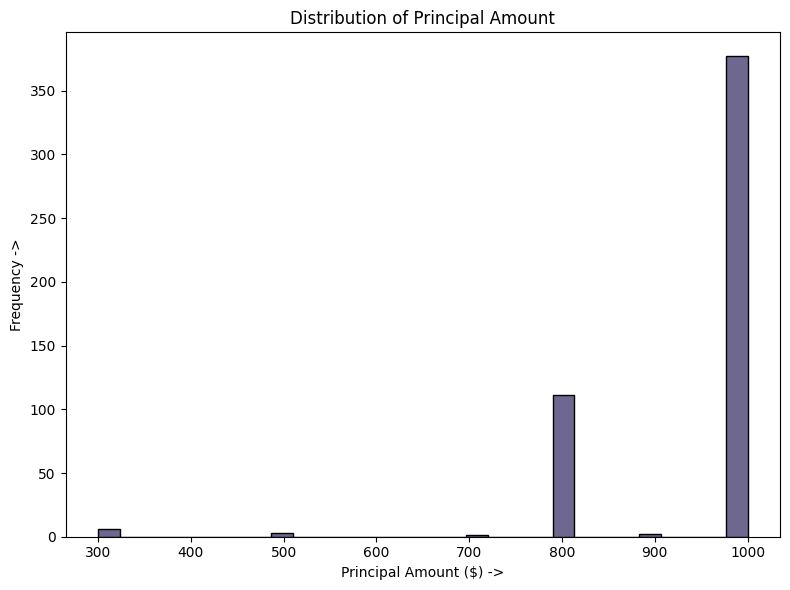

In [23]:
# Plot values of Principal
palette = sns.color_palette("mako", n_colors=7)
plt.figure(figsize=(8, 6))
sns.histplot(data['principal'], bins=30, color=palette[1])
plt.title('Distribution of Principal Amount')
plt.xlabel('Principal Amount ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

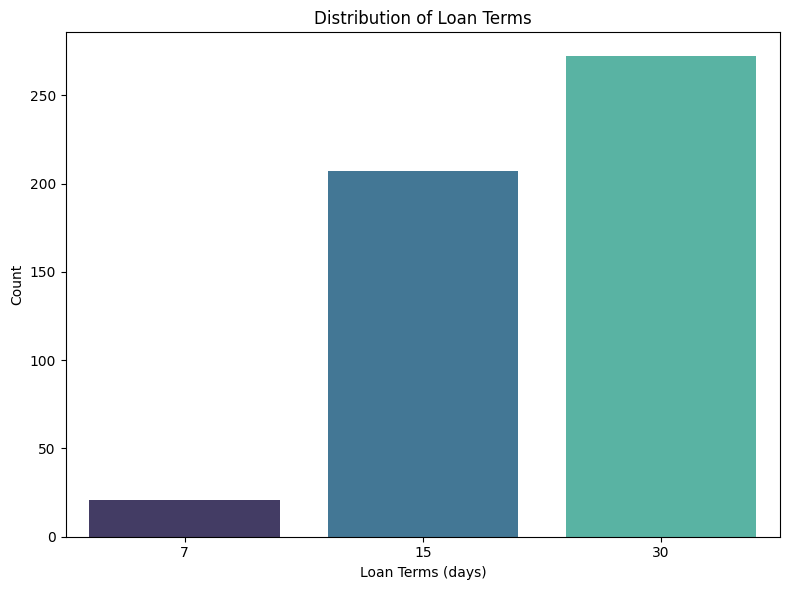

In [26]:
# Plot values of Terms
palette = sns.color_palette("mako", n_colors=3)
plt.figure(figsize=(8, 6))
sns.countplot(x='terms', hue='terms', data=data, palette=palette, legend=False)
plt.title('Distribution of Loan Terms')
plt.xlabel('Loan Terms (days)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

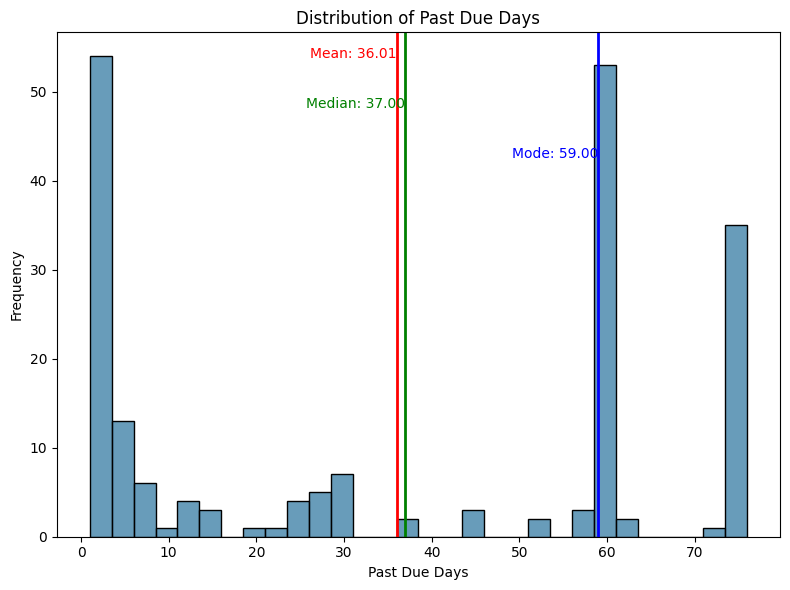

In [33]:
# Plot values of Past Due Days
palette = sns.color_palette("mako", n_colors=7)

# Calculate mean, median, and mode for the 'past_due_days' where it's greater than 0
past_due_days = data[data['past_due_days'] > 0]['past_due_days']
mean_val = past_due_days.mean()
median_val = past_due_days.median()
mode_val = past_due_days.mode().iloc[0]

# Plot the distribution and annotate mean, median, and mode
plt.figure(figsize=(8, 6))
sns.histplot(past_due_days, bins=30, color=palette[3])
plt.title('Distribution of Past Due Days')
plt.xlabel('Past Due Days')
plt.ylabel('Frequency')

# Mean - red line
plt.axvline(mean_val, color='red', linestyle='-', linewidth=2)
plt.text(mean_val, plt.ylim()[1]*0.95, f'Mean: {mean_val:.2f}', color = 'red', ha="right")

# Median - green line
plt.axvline(median_val, color='green', linestyle='-', linewidth=2)
plt.text(median_val, plt.ylim()[1]*0.85, f'Median: {median_val:.2f}', color = 'green', ha="right")

# Mode - blue line
plt.axvline(mode_val, color='blue', linestyle='-', linewidth=2)
plt.text(mode_val, plt.ylim()[1]*0.75, f'Mode: {mode_val:.2f}', color = 'blue', ha="right")

plt.tight_layout()
plt.show()


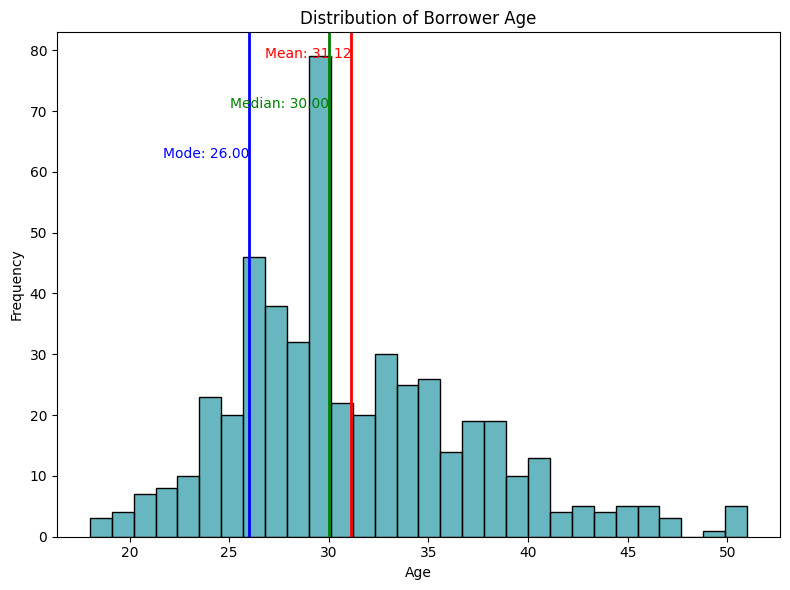

In [36]:
# Plot values of Age

# Calculate mean, median, and mode for the 'past_due_days' where it's greater than 0
past_due_days = data['age']
mean_val = past_due_days.mean()
median_val = past_due_days.median()
mode_val = past_due_days.mode().iloc[0]

plt.figure(figsize=(8, 6))
sns.histplot(data['age'], bins=30, color=palette[4])
plt.title('Distribution of Borrower Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Mean - red line
plt.axvline(mean_val, color='red', linestyle='-', linewidth=2)
plt.text(mean_val, plt.ylim()[1]*0.95, f'Mean: {mean_val:.2f}', color = 'red', ha="right")

# Median - green line
plt.axvline(median_val, color='green', linestyle='-', linewidth=2)
plt.text(median_val, plt.ylim()[1]*0.85, f'Median: {median_val:.2f}', color = 'green', ha="right")

# Mode - blue line
plt.axvline(mode_val, color='blue', linestyle='-', linewidth=2)
plt.text(mode_val, plt.ylim()[1]*0.75, f'Mode: {mode_val:.2f}', color = 'blue', ha="right")

plt.tight_layout()
plt.show()

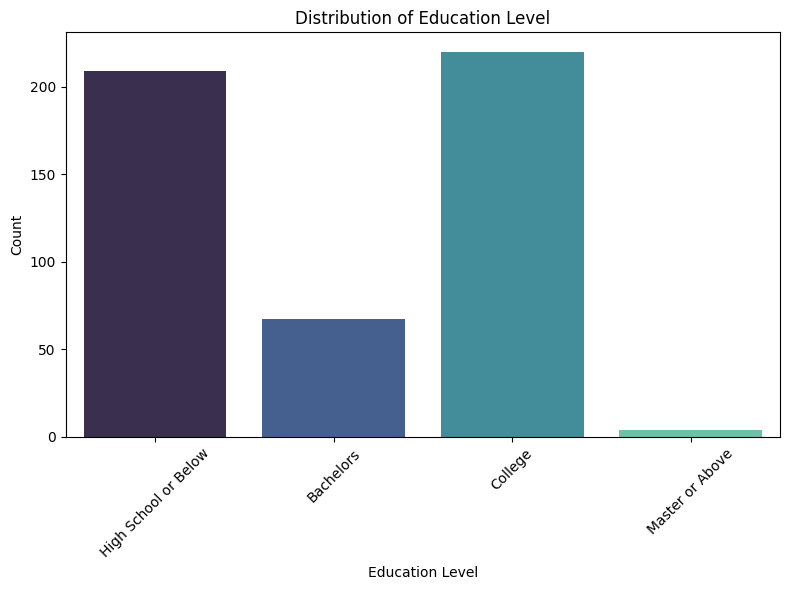

['High School or Below' 'Bachelors' 'College' 'Master or Above']


In [40]:
# Plot values of Education
palette = sns.color_palette("mako", n_colors=4)
plt.figure(figsize=(8, 6))
sns.countplot(x='education', hue='education', data=data, palette=palette)
plt.title('Distribution of Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


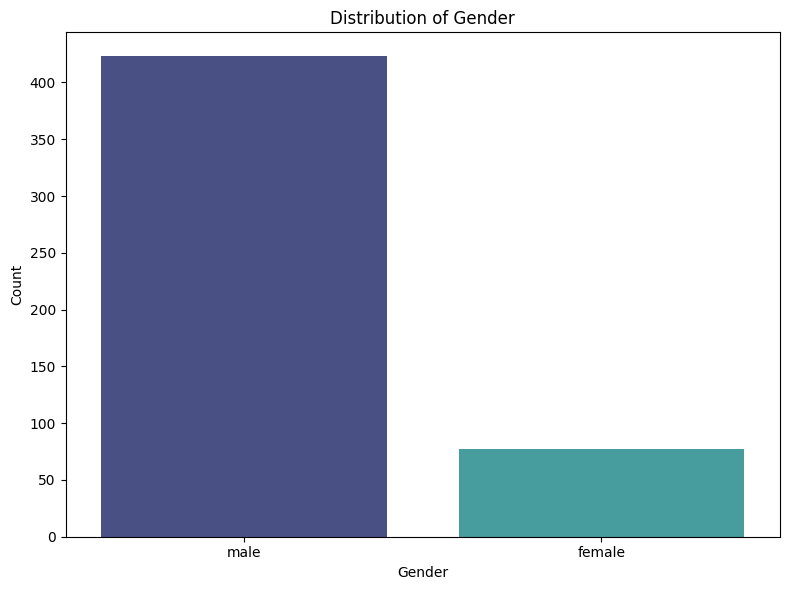

In [44]:
# Plot values of Gender

palette = sns.color_palette("mako", n_colors=2)
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='gender', data=data, palette=palette)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Building a Model

Now that we have a sense for the nuances of our dataset we can try building some models.

![analytics](utility/images/undraw_predictive_analytics_kf9n.png)

Before we continue, we will need to encode our categorical features with enumerations instead of the string values that they currently have. As a reminder, this is what our dataset looks like right now.

In [45]:
data.head()

,loan_status,principal,terms,past_due_days,age,education,gender
0,PAIDOFF,1000,30,0.0,45,High School or Below,male
1,PAIDOFF,1000,30,0.0,50,Bachelors,female
2,PAIDOFF,1000,30,0.0,33,Bachelors,female
3,PAIDOFF,1000,15,0.0,27,College,male
4,PAIDOFF,1000,30,0.0,28,College,female


An easy way to do this encoding is to use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from `sklearn`. In the cell below, we create a list called `categorical` containing the names of the columns corresponding to the categorical features in our dataset. We then create and instance of a `LabelEncoder` and use it to transform the categorical features.

In [46]:
from sklearn.preprocessing import LabelEncoder

categorical = ['loan_status', 'education', 'gender']

# create an instance of a LabelEncoder
encoder = LabelEncoder()

# make a copy of our data
encoded = data.copy()

# apply the encoder's `fit_transform` method to the values for each categorical
# feature column
encoded[categorical] = data[categorical].apply(encoder.fit_transform)

Let's take a look at the results.

In [47]:
encoded

,loan_status,principal,terms,past_due_days,age,education,gender
0,2,1000,30,0.0,45,2,1
1,2,1000,30,0.0,50,0,0
2,2,1000,30,0.0,33,0,0
3,2,1000,15,0.0,27,1,1
4,2,1000,30,0.0,28,1,0
...,...,...,...,...,...,...,...
495,1,1000,30,3.0,28,2,1
496,1,1000,15,14.0,26,2,1
497,1,800,15,3.0,30,1,1
498,1,1000,30,1.0,38,1,0


Notice how the categorical values like "PAIDOFF" have now been replaced with numbers. We can see which numbers map to each value like this:

In [48]:
for column in categorical:
    print(*sorted(zip(encoded[column].unique(), data[column].unique()), key=lambda x: x[0]))

(0, 'COLLECTION') (1, 'COLLECTION_PAIDOFF') (2, 'PAIDOFF')
(0, 'Bachelors') (1, 'College') (2, 'High School or Below') (3, 'Master or Above')
(0, 'female') (1, 'male')


Next let's separate our features from our target variable, `loan_status`.

In [49]:
X, y = encoded.loc[:, encoded.columns != 'loan_status'], encoded.loan_status

### Establishing a Baseline

Now we're ready to start building models. First, let's create a train/test split of our data.

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

Then, let's train and evaluate a LogisticRegression model.

In [51]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

**Try this!** In the cell below, evaluate the model's performance on the testing set using 2 different metrics. **[4 pts]**

In [59]:
# your code here
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'accuracy {accuracy}')
print("="*80)
print('confusion matrix:')
print(conf_matrix)
print("="*80)
print(class_report)

accuracy 0.97
confusion_matrix:
[[20  0  0]
 [ 1 17  2]
 [ 0  0 60]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.85      0.92        20
           2       0.97      1.00      0.98        60

    accuracy                           0.97       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.97      0.97      0.97       100



In [56]:
print(data['loan_status'].unique())

['PAIDOFF' 'COLLECTION' 'COLLECTION_PAIDOFF']


**Write-up!** How does our model perform on the test set? Explain your answer in terms of the metrics you chose to evaluate performance. **[2 pts]**

Let's also try looking at the model's performance on test examples of different genders.

In [61]:
print(f'''
validation (all) score: {model.score(X_test, y_test):0.3f}
validation (men) score: {model.score(X_test[X_test['gender'] == 1], y_test[X_test['gender'] == 1]):0.3f}
validation (women) score: {model.score(X_test[X_test['gender'] == 0], y_test[X_test['gender'] == 0]):0.3f}
''')


validation (all) score: 0.970
validation (men) score: 0.988
validation (women) score: 0.889



Yikes!

**Write-up!** What do you notice about these scores? How does these compare with the initial score we saw for the entire test set? What does this imply about our model? **[4 pts]**

### Dropping Gender

So our model is biased with respect to gender and gender is a feature of the model. Would it help to ignore the gender feature during training? Let's try it out.

Let's start by creating another train/test split, but this time using a copy of `X` and `y` that don't include `gender`.

In [62]:
X_without_gender = X.drop(['gender'], axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X_without_gender, y, test_size=0.2, stratify=y, random_state=3)

Let's see what `X_train` looks like now.

In [63]:
X_train.head()

,principal,terms,past_due_days,age,education
215,1000,30,0.0,29,1
196,1000,30,0.0,29,1
118,1000,30,0.0,35,0
432,800,7,2.0,34,0
496,1000,15,14.0,26,2


Now let's repeat our procedure for our baseline experiment.

In [64]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)

print(f'''

validation score: {model.score(X_test, y_test)}
validation (men) score: {model.score(X_test[X.iloc[X_test.index]['gender'] == 1],
                                     y_test[X.iloc[X_test.index]['gender'] == 1]):0.3f}
validation (women) score: {model.score(X_test[X.iloc[X_test.index]['gender'] == 0],
                                       y_test[X.iloc[X_test.index]['gender'] == 0]):0.3f}
''')



validation score: 0.97
validation (men) score: 0.988
validation (women) score: 0.889



The results are the same?

**Write-up!** What might this imply about our model and our data? Why may it not be a good idea to ignore "protected variables" like "gender" when training a model. Record your response below. **[4 pts]**

## 4. Becoming Data and Fairness Aware

![team](utility/images/undraw_team_spirit_hrr4.png)

The goal of this exercise was to demonstrate how an accuracy score can mislead you into thinking that your model is great and that your mission has been accomplished. By digging only a little bit deeper and evaluating our model's performance on each gender separately, we found that it performed very differently between genders. It was biased!

Just like that, while we were building a model to predict creditworthiness and loan repayment, we ran into the same problem Amazon did with their resume reviewing algorithm. Because the data we used was imbalanced, we introduced bias into our model unintentionally.

If you search online, you will find a myriad of ways that could be used to mitigate the effects of an imbalanced dataset. However, at the end of the day, the **best solution for both Amazon and us is to collect more complete data**.

We have only barely scratched the surface of fairness in Data Science. The field is both complex and emerging. If you are looking for more information about, I recommend starting with [Google's overview](https://developers.google.com/machine-learning/fairness-overview/) of the topic. The [AI Ethics Intro course by Kaggle](https://www.kaggle.com/learn/intro-to-ai-ethics) is another fantastic introductory resource, with more hands-on exercises such as this one. This [PAIR Explorable](https://pair.withgoogle.com/explorables/hidden-bias/) (to be covered in lecture on Nov 28th) offers a visual insight into hidden biases.